In [1]:
import utilities
import os
import json
import statistics
from prettytable import PrettyTable
from prettytable import ALL as ALL
# from scipy.stats import ttest_ind as ttest

In [2]:
# !pip3 install prettytable

In [478]:
DATA_DIR = '/media/umar/Data/work/voice-assistant-central/voice-assistants-openwpm/'
# DATA_DIR = '/media/umar/Data/work/voice-assistant-central/data/crawled-data-first-interaction/'
# DATA_DIR = '/media/umar/Data/work/voice-assistant-central/data/crawled-data-sixth-trained/'
RESULTS_DIR = '/media/umar/Data/work/voice-assistant-central/data/results/'

### Personas
```
Connected-Car
Dating
Fashion-Style
Pets-Animals
Religion-Spirituality
SmartHome
Wine-Beverages
Health-Fitness
Navigation-TripPlanners
```

In [358]:
# control_list = ['Plain', 'Plain-One', 'Plain-Two','Plain-Save-Profile', 'Amazon-Only', 'No-Skill', 'Synthetic-Health', 'Synthetic-Science', 'Synthetic-Computers']
control_list = ['Plain', 'Plain-One', 'Plain-Two', 'Amazon-Only', 'No-Skill', 'Synthetic-Health', 'Synthetic-Science', 'Synthetic-Computers']
# control_list = ['Plain', 'Plain-One', 'Plain-Two', 'Amazon-Only', 'No-Skill']

# 
# control_list = ['Plain', 'Amazon-Only', 'No-Skill']
test_list = ['Connected-Car', 'Dating', 'Fashion-Style', 'Pets-Animals', 'Religion-Spirituality', 'SmartHome', 'Wine-Beverages','Health-Fitness', 'Navigation-TripPlanners']

In [521]:
def get_forced_normal_websites_with_bids(bid_files):
    forced_count = 0
    normal_count = 0
    for bid_file in bid_files:
        if 'FORCED' in bid_file:
            forced_count += 1
        else:
            normal_count += 1

    return str(normal_count) + '/' + str(forced_count)


def get_websites_with_bids(bid_files):
    websites_with_bids = []
    for bid_file in bid_files:
        websites_with_bids.append(bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1])

    return websites_with_bids


def return_bid_cpms(bid_files):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            bid_cpms.append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_websites(bid_files, websites = []):
    bid_cpms = []
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            bid_cpms.append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_advertisers(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            bid_cpms[bid_json['bidder']].append(bid_json['cpm'])
    
    return bid_cpms


def return_bid_cpms_debug(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        all_bids = utilities.read_file(bid_file)

        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            bid_cpms[bid_json['bidder']].append((bid_json['cpm'], bid_file.rsplit('/')[-1]))
    
    return bid_cpms


def return_median_cpms(bid_files):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        current_bid_cpms = []
        for bid in all_bids:
            bid_json = json.loads(bid)
            current_bid_cpms.append(bid_json['cpm'])
            
        bid_cpms.append(statistics.median(current_bid_cpms))
    
    return bid_cpms


def return_median_cpms_websites(bid_files, websites = []):
    bid_cpms = []
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        current_bid_cpms = []
        for bid in all_bids:
            bid_json = json.loads(bid)
            current_bid_cpms.append(bid_json['cpm'])
            
        bid_cpms.append(statistics.median(current_bid_cpms))
    
    return bid_cpms


def return_median_cpms_advertisers(bid_files, advertisers, websites = []):
    bid_cpms = {}
    
    for bid_file in bid_files:
        all_bids = utilities.read_file(bid_file)
        
        bid_website = bid_file.rsplit('/', 1)[1].rsplit('_', 1)[1]
        if len(websites) > 0 and bid_website not in websites:
            continue
            
        current_bid_cpms = {}
        for bid in all_bids:
            bid_json = json.loads(bid)
            
            if bid_json['bidder'] not in advertisers:
                continue
            
            if bid_json['bidder'] not in bid_cpms:
                bid_cpms[bid_json['bidder']] = []
            
            if bid_json['bidder'] not in current_bid_cpms:
                current_bid_cpms[bid_json['bidder']] = []
            
            current_bid_cpms[bid_json['bidder']].append(bid_json['cpm'])
         
        for bidder in current_bid_cpms:
            bid_cpms[bidder].append(statistics.median(current_bid_cpms[bidder]))
    
    return bid_cpms


def return_common_websites(persona_list, data_dir):
    persona_dir = os.path.join(data_dir, persona_list[0] + '/website_bids/')
    common_websites = set(get_websites_with_bids(utilities.get_files_in_a_directory(persona_dir)))
    
    for persona in persona_list[1:]:
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        candidates = get_websites_with_bids(utilities.get_files_in_a_directory(persona_dir))
        common_websites = common_websites.intersection(candidates)
        
    return common_websites


def ptable_to_csv(table, filename, headers=True):
    """Save PrettyTable results to a CSV file.

    Adapted from @AdamSmith https://stackoverflow.com/questions/32128226

    :param PrettyTable table: Table object to get data from.
    :param str filename: Filepath for the output CSV.
    :param bool headers: Whether to include the header row in the CSV.
    :return: None
    """
    raw = table.get_string()
    data = [tuple(filter(None, map(str.strip, splitline)))
            for line in raw.splitlines()
            for splitline in [line.split('|')] if len(splitline) > 1]
    if table.title is not None:
        data = data[1:]
    if not headers:
        data = data[1:]
    with open(filename, 'w') as f:
        for d in data:
            f.write('{}\n'.format(','.join(d)))

### Reading bids for personas

In [522]:
def compute_bid_statistics(persona_list, data_dir, common_websites=[], get_median=False):
    persona_stat_map = {}
    cpms_personas = {}
    
    for persona in persona_list:
        persona_stat_map[persona] = {}
        cpms_personas[persona] = set()
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        
        bid_files_raw = utilities.get_files_in_a_directory(persona_dir)
        bid_files = []
        bid_files =  bid_files_raw
        
#         for item in bid_files_raw:
#             if int(item.rsplit('_',3)[1]) < 840:
#                 bid_files.append(item)
            
        
        persona_stat_map[persona]['normal-forced'] = get_forced_normal_websites_with_bids(bid_files)
        
        if get_median:
            cpms = return_median_cpms_websites(bid_files, common_websites)
        else:
            cpms = return_bid_cpms_websites(bid_files, common_websites)
            
        cpms_personas[persona] = cpms

        persona_stat_map[persona]['median'] = "{0:0.3f}".format(statistics.median(cpms))
        persona_stat_map[persona]['mean'] = "{0:0.3f}".format(statistics.mean(cpms))
        persona_stat_map[persona]['min'] = "{0:0.3f}".format(min(cpms))
        persona_stat_map[persona]['max'] = "{0:0.3f}".format(max(cpms))
        persona_stat_map[persona]['sd'] = "{0:0.3f}".format(statistics.stdev(cpms))

        persona_stat_map[persona]['total_bids'] = len(cpms)
        normal, forced = persona_stat_map[persona]['normal-forced'].split('/')
        persona_stat_map[persona]['total_websites'] = int(normal) + int(forced)
        
        persona_stat_map[persona]['common_websites'] = len(common_websites) if len(common_websites) > 0 else '-'

    return persona_stat_map, cpms_personas

In [523]:
def print_bid_statistics(persona_stat_map, persona_list):
    
    table = PrettyTable(['Measure'] + persona_list, hrules=ALL)
    
    table.add_row(['# of websites'] + [persona_stat_map[persona]['total_websites'] for persona in persona_list])
    table.add_row(['Common websites'] + [persona_stat_map[persona]['common_websites'] for persona in persona_list])
    table.add_row(['Normal/Forced'] + [persona_stat_map[persona]['normal-forced'] for persona in persona_list])
    table.add_row(['# of bids'] + [persona_stat_map[persona]['total_bids'] for persona in persona_list])
        
    table.add_row(['Median'] + [persona_stat_map[persona]['median'] for persona in persona_list])

    table.add_row(['Mean'] + [persona_stat_map[persona]['mean'] for persona in persona_list])
    table.add_row(['SD'] + [persona_stat_map[persona]['sd'] for persona in persona_list])
    table.add_row(['Min'] + [persona_stat_map[persona]['min'] for persona in persona_list])
    table.add_row(['Max'] + [persona_stat_map[persona]['max'] for persona in persona_list])
    
    print(table)
    
    return table

## Consider all websites and all bids

In [524]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'all-bids.csv')

+-----------------+--------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain  | Plain-One | Plain-Two | Amazon-Only | No-Skill | Synthetic-Health | Synthetic-Science | Synthetic-Computers | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+--------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   43   |     35    |     30    |      31     |    32    |        48        |         35        |          4

### Consider bids on websites where bids returned for all personas

In [538]:
common_websites = return_common_websites(control_list + test_list, DATA_DIR)

persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, common_websites)
table = print_bid_statistics(persona_stat_map, control_list + test_list)

ptable_to_csv(table, RESULTS_DIR + 'common-bids.csv')

+-----------------+-------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Measure     | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Synthetic-Health | Synthetic-Science | Synthetic-Computers | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-----------------+-------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|  # of websites  |   43  |     35    |     30    |      31     |    32    |        48        |         35        |          41   

### Consider medain bids on websites 

In [ ]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, get_median=True)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'all-median-bids.csv')

### Consider medain bids on websites where bids returned for all personas

In [492]:
common_websites = return_common_websites(control_list + test_list, DATA_DIR)

In [ ]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, common_websites, get_median=True)
table = print_bid_statistics(persona_stat_map, control_list + test_list)
ptable_to_csv(table, RESULTS_DIR + 'common-median-bids.csv')

In [493]:
common_websites

{'gismeteo.ru',
 'investopedia.com',
 'mapquest.com',
 'myanimelist.net',
 'observer.com',
 'thoughtco.com'}

### Get most prevalent bidders by persona

In [371]:
def get_prevalent_advertisers(persona_list, data_dir):
    advertisers = {}
    
    for persona in persona_list:
        advertisers[persona] = {}
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        bid_files = utilities.get_files_in_a_directory(persona_dir)
        
        for bid_file in bid_files:
            all_bids = utilities.read_file(bid_file)
            local_advertisers = set()

            for bid in all_bids:
                bid_json = json.loads(bid)

                if bid_json['bidder'] in local_advertisers:
                    continue
                else:
                    local_advertisers.add(bid_json['bidder'])

                if bid_json['bidder'] not in advertisers[persona]:
                    advertisers[persona][bid_json['bidder']] = 0
                
                advertisers[persona][bid_json['bidder']] += 1
                
    return advertisers


def get_prevalent_advertisers_all_bids(persona_list, data_dir):
    advertisers = {}
    
    for persona in persona_list:
        advertisers[persona] = {}
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        bid_files = utilities.get_files_in_a_directory(persona_dir)
        
        for bid_file in bid_files:
            all_bids = utilities.read_file(bid_file)
#             local_advertisers = set()

            for bid in all_bids:
                bid_json = json.loads(bid)

#                 if bid_json['bidder'] in local_advertisers:
#                     continue
#                 else:
#                     local_advertisers.add(bid_json['bidder'])

                if bid_json['bidder'] not in advertisers[persona]:
                    advertisers[persona][bid_json['bidder']] = 0
                
                advertisers[persona][bid_json['bidder']] += 1
                
    return advertisers


def get_common_advertisers(advertisers):
    common_advertisers = set()
    
    for persona in advertisers:
        if len(common_advertisers) == 0:
            common_advertisers = set(advertisers[persona].keys())
            
        common_advertisers = common_advertisers.intersection(advertisers[persona].keys())
            
    return common_advertisers


def get_all_advertisers(advertisers):
    all_advertisers = set()
    for persona in advertisers:
         all_advertisers |= set(advertisers[persona].keys())
            
    return all_advertisers


# def get_top_n_advertiser_per_persona(advertisers):
    

def print_bidders(advertisers, common_advertisers):
    
    table = PrettyTable(['Advertiser'] + list(advertisers.keys()), hrules=ALL)
    
    for advertiser in common_advertisers:
        table.add_row([advertiser] + [advertisers[persona][advertiser] if advertiser in advertisers[persona] else 0 for persona in advertisers.keys()])        
    
    print(table)
    
    return table

In [494]:
# advertisers = get_prevalent_advertisers(control_list + test_list, DATA_DIR)
advertisers = get_prevalent_advertisers_all_bids(control_list + test_list, DATA_DIR)
common_advertisers = get_common_advertisers(advertisers)
all_advertisers = get_all_advertisers(advertisers)
table = print_bidders(advertisers, all_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'all_advertisers.csv')

+-------------------+-------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     Advertiser    | Plain | Plain-One | Plain-Two | Amazon-Only | No-Skill | Synthetic-Health | Synthetic-Science | Synthetic-Computers | Connected-Car | Dating | Fashion-Style | Pets-Animals | Religion-Spirituality | SmartHome | Wine-Beverages | Health-Fitness | Navigation-TripPlanners |
+-------------------+-------+-----------+-----------+-------------+----------+------------------+-------------------+---------------------+---------------+--------+---------------+--------------+-----------------------+-----------+----------------+----------------+-------------------------+
|     districtm     |   0   |     0     |     0     |      0      |    0     |        0         |         0         |       

In [500]:
def compute_bid_statistics(persona_list, data_dir, common_advertisers, common_websites=[], get_median=False):
    persona_stat_map = {}
#     common_advertisers.remove('pubmatic')
#     common_advertisers.remove('ix')
#     common_advertisers.remove('rubicon')
    cpms_personas = {}
    
    for persona in persona_list:
        persona_stat_map[persona] = {}
        cpms_personas[persona] = set()
        
        persona_dir = os.path.join(data_dir, persona + '/website_bids/')
        
        bid_files = utilities.get_files_in_a_directory(persona_dir)
#         persona_stat_map[persona]['normal-forced'] = get_forced_normal_websites_with_bids(bid_files, common_advertisers)
        
        if get_median:
            cpms = return_median_cpms_advertisers(bid_files, common_advertisers, common_websites)
        else:
            cpms = return_bid_cpms_advertisers(bid_files, common_advertisers, common_websites)
        
        cpms_personas[persona] = cpms
        for advertiser in common_advertisers: 
            persona_stat_map[persona][advertiser] = {}
         
            persona_stat_map[persona][advertiser]['median'] = "{0:0.3f}".format(statistics.median(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['mean'] = "{0:0.3f}".format(statistics.mean(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['min'] = "{0:0.3f}".format(min(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['max'] = "{0:0.3f}".format(max(cpms[advertiser]) if advertiser in cpms else 0)
            persona_stat_map[persona][advertiser]['sd'] = "{0:0.3f}".format(statistics.stdev(cpms[advertiser]) if advertiser in cpms and len(cpms[advertiser]) > 1 else 0)

            persona_stat_map[persona][advertiser]['total_bids'] = len(cpms[advertiser]) if advertiser in cpms else 0
        
#         normal, forced = persona_stat_map[persona]['normal-forced'].split('/')
#         persona_stat_map[persona]['total_websites'] = int(normal) + int(forced)
        
#         persona_stat_map[persona]['common_websites'] =  len(common_websites) if len(common_websites) > 0 else '-'

    return persona_stat_map, cpms_personas



def print_common_bidders(persona_stat_map, common_advertisers):

    table = PrettyTable(['Persona'] + list(common_advertisers), hrules=ALL)
    
    for persona in persona_stat_map:
        table.add_row([persona] + [str(persona_stat_map[persona][advertiser]['mean']) + '/' + str(persona_stat_map[persona][advertiser]['sd'])  for advertiser in list(common_advertisers)])
    
    print(table)
    return table

In [501]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, all_advertisers, [], get_median = False)
table = print_common_bidders(persona_stat_map, all_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'all_advertisers_mean_sd_bids.csv')

+-------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------------+-------------+--------------+-------------+-------------+-------------+---------------+--------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+--------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+
|         Persona         |  districtm  |    sonobi   |   verizon   |    trustx   | emx_digital |  triplelift |  adyoulike  |    gumgum   |  onemobile  |   appnexus  |  eplanning  |   medianet  | interactiveOffers |    sovrn    | sharethrough |   rubicon   |   yahoossp  |   pubm_ss   | indexExchange | richaudience | smartadse

In [496]:
persona_stat_map, cpms_personas = compute_bid_statistics(control_list + test_list, DATA_DIR, all_advertisers, common_websites, get_median = False)
table = print_common_bidders(persona_stat_map, all_advertisers)
ptable_to_csv(table, RESULTS_DIR + 'common_advertisers_bids.csv')

+-------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------------+-------------+--------------+-------------+-------------+-------------+---------------+--------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+
|         Persona         |  districtm  |    sonobi   |   verizon   |    trustx   | emx_digital |  triplelift |  adyoulike  |    gumgum   |  onemobile  |   appnexus  |  eplanning  |   medianet  | interactiveOffers |    sovrn    | sharethrough |   rubicon   |   yahoossp  |   pubm_ss   | indexExchange | richaudience | smartadser

In [ ]:
common_advertisers

In [ ]:
ttest(common_control_cpms, common_test_cpms)

### Rough work

In [ ]:
persona_dir = os.path.join(DATA_DIR, 'SmartHome/website_bids/')

bid_files = utilities.get_files_in_a_directory(persona_dir)

cpms = return_bid_cpms_debug(bid_files, all_advertisers, [])

In [ ]:
cpms

In [ ]:
common_advertisers

# Plot results

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

In [ ]:
# ! pip install numpy

In [ ]:
cpms_personas

In [ ]:
advertisers

In [ ]:
# advertisers

k = dict(sorted(advertisers['Plain'].items(), key=lambda item: item[1], reverse=True))
# k = sorted(advertisers['Plain'].items(), key=operator.itemgetter(1), reverse=reverse)

# pubmatic
# openx
# triplelift
# criteo
# appnexus
# rubicon
# ix
# getapp
# onemobile

# ozone
# smartadserver


In [375]:
control_test_labels = control_list[:-3] + test_list + control_list[-3:]
# control_test_labels = control_list + test_list

In [527]:
data = []

for persona in control_test_labels:
    data.append(cpms_personas[persona])
    
x_data = np.arange(len(control_list + test_list)) + 1

## Execute this for select advertisers only

In [ ]:
select_advertisers = ['pubmatic','openx','triplelift','criteo','appnexus','rubicon','ix','getapp','onemobile', 'ozone','smartadserver', 'ias']

In [482]:
# select_advertisers = ['pubmatic','openx','districtmDMX','rubicon','ix','indexExchange','smaato', 'verizon', 'yahoossp', 'aol']
# select_advertisers = ['pubmatic','openx','districtmDMX','rubicon','ix','indexExchange','smaato', 'triplelift', 'pubnative', 'appnexus']
select_advertisers = ['pubmatic','openx','districtmDMX','rubicon','ix','indexExchange','smaato', 'triplelift', 'pubnative', 'appnexus', 'verizon', 'yahoossp', 'aol']

In [ ]:
# UAM: district m, OpenX, Pubmatic, Magnite Index Exchange, Smaato and more.

# TAM:
# OpenX
# Magnite
# Smaato
# SpotX
# TripleLift
# Verve
# Xandr

In [ ]:
# DistrictM --> districtmDMX
# OpenX
# Pubmatic
# Rubicon/Magnite
# Verizon
# Index Exchange --> IX , indexExchange
# Smaato


In [525]:
data = []
for persona in control_test_labels:
    tmp = []
    for advertiser in select_advertisers:
#     for advertiser in common_advertisers:
        if advertiser not in cpms_personas[persona]:
            continue
        tmp += cpms_personas[persona][advertiser]
    
    data.append(tmp)
    
x_data = np.arange(len(control_list + test_list)) + 1

In [354]:
for bids in data:
    print(len(bids))

91
59
78
79
72
98
194
96
83
97
69
162
107
79
143
150
137


In [355]:
new_bids = []
new_data = []
for bids in data:
    new_bids = bids + [0] * (194 - len(bids))
    new_data.append(new_bids)
data = new_data

In [268]:
# new_data

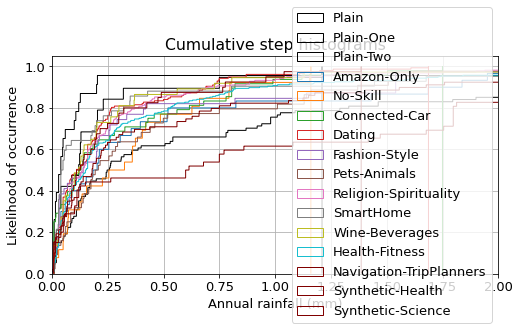

In [508]:
np.random.seed(19680801)

# mu = 200
# sigma = 25
# n_bins = 50
# x = np.random.normal(mu, sigma, size=100)

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(data[0], 50000, color='black', label = control_test_labels[0], density=True, histtype='step', cumulative=True)
n, bins, patches = ax.hist(data[1], 50000, color='black', label = control_test_labels[1], density=True, histtype='step', cumulative=True)
n, bins, patches = ax.hist(data[2], 50000, color='black', label = control_test_labels[2], density=True, histtype='step', cumulative=True)

for i in range(3,13):
    n, bins, patches = ax.hist(data[i], 50000, color=plt.cm.get_cmap('tab10').colors[i-3], label = control_test_labels[i], density=True, histtype='step', cumulative=True)
    
# n, bins, patches = ax.hist(data[10], 50000, color='black', label = control_test_labels[10], density=True, histtype='step', cumulative=True)
# n, bins, patches = ax.hist(data[11], 50000, color='yellow', label = control_test_labels[11], density=True, histtype='step', cumulative=True)
# n, bins, patches = ax.hist(data[12], 50000, color='magenta', label = control_test_labels[12], density=True, histtype='step', cumulative=True)
n, bins, patches = ax.hist(data[13], 50000, color='maroon', label = control_test_labels[13], density=True, histtype='step', cumulative=True)
n, bins, patches = ax.hist(data[14], 50000, color='maroon', label = control_test_labels[14], density=True, histtype='step', cumulative=True)
n, bins, patches = ax.hist(data[15], 50000, color='maroon', label = control_test_labels[15], density=True, histtype='step', cumulative=True)



# # Add a line showing the expected distribution.
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# y = y.cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# # Overlay a reversed cumulative histogram.
# ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
#         label='Reversed emp.')

# tidy up the figure
ax.set_xlim([0, 2])


ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Annual rainfall (mm)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

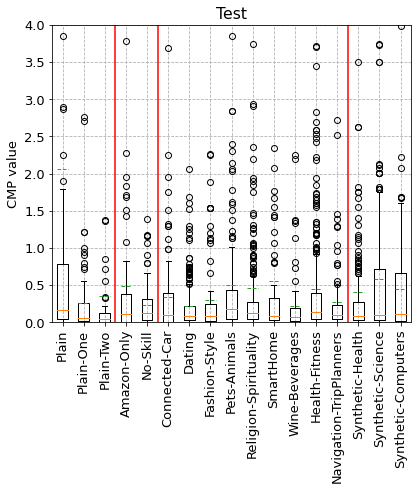

In [528]:
fig, ax = plt.subplots()
_ = ax.boxplot(data, showfliers=True, manage_ticks=True,autorange=True,meanline=True,showmeans=True)

ax.set_ylabel('CMP value')
ax.set_xticks(x_data)
ax.set_xticklabels(control_test_labels, rotation=90)

# ax.legend(loc="upper left")
ax.set_ylim([0, 4])
# ax.set_yticks([0.5]*20)
fig.set_size_inches(6, 7, forward=True)

ax.vlines(3.5, 0, 8, colors='red', linestyles='solid', label='',)
ax.vlines(5.5, 0, 8, colors='red', linestyles='solid', label='',)
ax.vlines(14.5, 0, 8, colors='red', linestyles='solid', label='',)

label_text = 'Test'
plt.title(label_text)
plt.grid(linestyle='--')
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR + label_text + ".pdf")
plt.show()

In [441]:
data

[[0.161, 0.043],
 [],
 [0.1],
 [0.07400000000000001, 0.184, 0.04],
 [0.07150000000000001, 0.226],
 [0.092, 0.138],
 [0.19, 0.195, 0.41, 0.7949999999999999, 0.275, 0.184428],
 [0.0615, 0.292],
 [1.62, 0.175, 0.28300000000000003],
 [0.51, 0.079, 0.193, 0.45, 2.215, 0.05, 0.13, 0.17, 1.264747],
 [0.321, 0.064],
 [0.175],
 [1.17, 0.276, 0.0765, 0.52, 0.71, 0.56, 0.06, 1.264747],
 [0.191, 0.0815],
 [0.18, 0.2155],
 [0.101, 0.0415],
 [1.48, 0.118]]

In [101]:
import pandas as pd

In [102]:
# !pip install pandas

In [529]:
df = pd.DataFrame(data)
df = df.transpose()
df.columns = control_test_labels

In [530]:
Q1 = df.quantile(0.25)
Q2 = df.quantile(0.50)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [154]:
Q1, Q2, Q3, (Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR)

(Plain                      0.606323
 Plain-One                  0.787000
 Plain-Two                  0.152000
 Amazon-Only                0.325276
 No-Skill                   0.249808
 Connected-Car              0.343700
 Dating                     0.315250
 Fashion-Style              0.360000
 Pets-Animals               1.139750
 Religion-Spirituality      0.610000
 SmartHome                  0.241072
 Wine-Beverages             0.475000
 Health-Fitness             0.393402
 Navigation-TripPlanners    0.530000
 Synthetic-Health           0.399750
 Synthetic-Science               NaN
 Synthetic-Computers        0.326049
 Name: 0.25, dtype: float64,
 Plain                      0.620000
 Plain-One                  0.980000
 Plain-Two                  0.650000
 Amazon-Only                0.560000
 No-Skill                   0.249808
 Connected-Car              0.360000
 Dating                     0.524000
 Fashion-Style              0.510000
 Pets-Animals               1.296500
 Religion

In [531]:
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum() 

Plain                      18
Plain-One                  10
Plain-Two                   8
Amazon-Only                10
No-Skill                    8
Connected-Car              11
Dating                     29
Fashion-Style              14
Pets-Animals               17
Religion-Spirituality      37
SmartHome                  15
Wine-Beverages              9
Health-Fitness             44
Navigation-TripPlanners    13
Synthetic-Health           30
Synthetic-Science          18
Synthetic-Computers         7
dtype: int64

In [ ]:
df[(df > (Q3 + 1.5 * IQR))].mean()

In [ ]:
tmp

In [532]:
(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum() / (df.count())) * 100.0

Plain                      12.413793
Plain-One                  13.513514
Plain-Two                  11.267606
Amazon-Only                13.888889
No-Skill                    9.195402
Connected-Car              11.702128
Dating                     13.425926
Fashion-Style              15.555556
Pets-Animals               18.085106
Religion-Spirituality      12.171053
SmartHome                  14.851485
Wine-Beverages              9.677419
Health-Fitness             11.989101
Navigation-TripPlanners    14.285714
Synthetic-Health           16.483516
Synthetic-Science          15.000000
Synthetic-Computers         4.794521
dtype: float64

In [ ]:
Fourth
Plain                       4.444444
Plain-One                   8.888889
Plain-Two                   9.905660
Amazon-Only                 8.020050
No-Skill                   15.857605
Synthetic-Health           12.419700
Synthetic-Science           7.857143
Synthetic-Computers        11.962617
Connected-Car              10.909091
Dating                      7.258065
Fashion-Style               8.914729
Pets-Animals                4.363636
Religion-Spirituality       9.160305
SmartHome                   9.782609
Wine-Beverages              8.219178
Health-Fitness              9.009009
Navigation-TripPlanners     6.549118

In [ ]:
Fourth -- 100
Plain                       4.444444
Plain-One                   9.876543
Plain-Two                  16.000000
Plain-Save-Profile          4.109589
Amazon-Only                10.958904
No-Skill                    1.075269
Synthetic-Health           13.809524
Synthetic-Science           9.433962
Synthetic-Computers        14.814815
Connected-Car              15.384615
Dating                      0.000000
Fashion-Style               8.737864
Pets-Animals               10.752688
Religion-Spirituality      11.818182
SmartHome                  21.052632
Wine-Beverages             10.084034
Health-Fitness             14.814815
Navigation-TripPlanners     9.876543

In [ ]:
Third
Plain                       5.882353
Plain-One                   3.061224
Plain-Two                   6.206897
Amazon-Only                 4.807692
No-Skill                   13.684211
Connected-Car              11.764706
Dating                      7.865169
Fashion-Style               9.411765
Pets-Animals                8.888889
Religion-Spirituality       5.855856
SmartHome                  11.607143
Wine-Beverages              2.870813
Health-Fitness             17.391304
Navigation-TripPlanners     1.162791

In [ ]:
top_points = _["fliers"][0].get_data()[1]
bottom_points = _["fliers"][2].get_data()[1]

In [ ]:
len(top_points), len(bottom_points)

In [ ]:
import itertools

In [ ]:
x_index = [[i+1]*len(data[i]) for i,item in enumerate(data)]
# x, y = np.meshgrid(x_zeros,data)
x_index = list(itertools.chain.from_iterable(x_index))
y_index = list(itertools.chain.from_iterable(data))
plt.scatter(x_index,y_index)
plt.show()

In [533]:
from scipy import stats

In [ ]:
# ! pip install scipy

In [ ]:
1 – (2U)/(n1 n2)

In [539]:
table = PrettyTable(['Persona', 'Plain(P)', 'Plain(E)', 'Amazon-Only(P)', 'Amazon-Only(E)', 'No-Skill(P)', 'No-Skill(E)'], hrules=ALL)
# for control_persona in ['Plain', 'Amazon-Only', 'No-Skill']:
for test_persona in test_list + ['Synthetic-Health', 'Synthetic-Science', 'Synthetic-Computers']:
    plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas[test_persona])
    Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas[test_persona])
    NoSkl_mu = stats.mannwhitneyu(cpms_personas['No-Skill'], cpms_personas[test_persona])
    
    plain_p = "{0:0.5f}".format(plain_mu.pvalue)
    Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)
    NoSkl_p = "{0:0.5f}".format(NoSkl_mu.pvalue)
    
    plain_e = "{0:0.5f}".format(1 - ((2 * plain_mu.statistic) / (len(cpms_personas['Plain'])*len(cpms_personas[test_persona]))))
    Amazn_e = "{0:0.5f}".format(1 - ((2 * Amazn_mu.statistic) / (len(cpms_personas['Amazon-Only'])*len(cpms_personas[test_persona]))))
    NoSkl_e = "{0:0.5f}".format(1 - ((2 * NoSkl_mu.statistic) / (len(cpms_personas['No-Skill'])*len(cpms_personas[test_persona]))))


    table.add_row([test_persona, plain_p, plain_e, Amazn_p, Amazn_e, NoSkl_p, NoSkl_e])
#         print(control_persona, test_persona, stats.mannwhitneyu(cpms_personas[control_persona], cpms_personas[test_persona]).pvalue)
print(table)

+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|         Persona         | Plain(P) | Plain(E) | Amazon-Only(P) | Amazon-Only(E) | No-Skill(P) | No-Skill(E) |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|      Connected-Car      | 0.81711  | 0.05430  |    0.15172     |    -0.30672    |   0.66606   |   -0.08997  |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|          Dating         | 0.03711  | 0.40849  |    0.71648     |    -0.07143    |   0.18281   |   0.23935   |
+-------------------------+----------+----------+----------------+----------------+-------------+-------------+
|      Fashion-Style      | 0.31842  | 0.25385  |    0.59733     |    -0.13571    |   0.63274   |   0.11765   |
+-------------------------+----------+----------+----------------+----------------+-------------+-------

In [540]:
table = PrettyTable(['Persona', 'Plain', 'Amazon-Only', 'No-Skill'], hrules=ALL)
# for control_persona in ['Plain', 'Amazon-Only', 'No-Skill']:
for test_persona in test_list:
    plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas[test_persona])
    Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas[test_persona])
    NoSkl_mu = stats.mannwhitneyu(cpms_personas['No-Skill'], cpms_personas[test_persona])
    
    plain_p = "{0:0.5f}".format(plain_mu.pvalue)
    Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)
    NoSkl_p = "{0:0.5f}".format(NoSkl_mu.pvalue)
    
    plain_e = "{0:0.5f}".format(1 - ((2 * plain_mu.statistic) / (len(cpms_personas['Plain'])*len(cpms_personas[test_persona]))))
    Amazn_e = "{0:0.5f}".format(1 - ((2 * Amazn_mu.statistic) / (len(cpms_personas['Amazon-Only'])*len(cpms_personas[test_persona]))))
    NoSkl_e = "{0:0.5f}".format(1 - ((2 * NoSkl_mu.statistic) / (len(cpms_personas['No-Skill'])*len(cpms_personas[test_persona]))))


    table.add_row([test_persona, plain_p, Amazn_p, NoSkl_p])
#         print(control_persona, test_persona, stats.mannwhitneyu(cpms_personas[control_persona], cpms_personas[test_persona]).pvalue)

plain_mu = stats.mannwhitneyu(cpms_personas['Plain'], cpms_personas['No-Skill'])
Amazn_mu = stats.mannwhitneyu(cpms_personas['Amazon-Only'], cpms_personas['No-Skill'])

plain_p = "{0:0.5f}".format(plain_mu.pvalue)
Amazn_p = "{0:0.5f}".format(Amazn_mu.pvalue)

table.add_row(['No-Skill', plain_p, Amazn_p, '--'])

print(table)

ptable_to_csv(table, RESULTS_DIR + 'u-test.csv')

+-------------------------+---------+-------------+----------+
|         Persona         |  Plain  | Amazon-Only | No-Skill |
+-------------------------+---------+-------------+----------+
|      Connected-Car      | 0.81711 |   0.15172   | 0.66606  |
+-------------------------+---------+-------------+----------+
|          Dating         | 0.03711 |   0.71648   | 0.18281  |
+-------------------------+---------+-------------+----------+
|      Fashion-Style      | 0.31842 |   0.59733   | 0.63274  |
+-------------------------+---------+-------------+----------+
|       Pets-Animals      | 0.04590 |   0.74736   | 0.05646  |
+-------------------------+---------+-------------+----------+
|  Religion-Spirituality  | 0.04713 |   0.98868   | 0.09091  |
+-------------------------+---------+-------------+----------+
|        SmartHome        | 0.17129 |   0.95625   | 0.16459  |
+-------------------------+---------+-------------+----------+
|      Wine-Beverages     | 0.61428 |   0.32742   | 0.9

In [ ]:
stats.normaltest(cpms_personas['Amazon-Only'])

In [ ]:
def read_json(file_addr):
    with open(file_addr) as json_data:
        d = json.load(json_data)
    
    websites_list = []

    count = 1
    for key in d:
        for item in d[key]:
            websites_list.append(str(count)+','+item)
            count += 1

    return websites_list



In [ ]:
sites = read_json('/media/umar/Data/work/voice-assistant-central/voice-assistants-openwpm/top_websites/Synthetic-Computers.json')
# sites = read_file('tranco_09072021_10K.csv')[:10]

In [ ]:
sites

In [ ]:
def read_file(file_addr):
    with open(file_addr) as f:
        content = f.readlines()
    return content

sites = read_file('/media/umar/Data/work/voice-assistant-central/voice-assistants-openwpm/top_websites/top_prebid_websites.csv')[:200]

In [ ]:
sites